### Тематическое моделирование

Файл data.txt содержит информацию о статьях, связанных с круглыми червями (Nematoda). 

Для проведения тематического моделирования необходимо:
1. обработать файл с помощью регулярных выражений (оставить только абстракты);
2. предобработать текста (удаление лишних символов и стоп-слов, лемматизация);
3. выбрать выбрать метод и нужное количество топиков для тематического моделирования;
4. визулизацировать темы гистограммой (статическая визуализация).

In [1]:
import pandas as pd
import numpy as np
import re

### 1. Загрузка данных

In [2]:
f = open('data.txt', 'r', encoding='ISO-8859-1')
data = f.read()
f.close()

In [3]:
data_split = re.split(
    r'(Key:|Medline:|Authors:|Title:|Citation:|Type:|Genes:|Abstract:)', data
)[1:]

In [4]:
data_split[:6]

['Key:',
 '    3\n    ',
 'Medline:',
 '\n    ',
 'Authors:',
 ' Abdulkader N;Brun JL\n      ']

In [5]:
# функция, которая создает кортеж, состоящий из n элементов, из списка data
def grouper(data, n):
    args = [iter(data)] * n
    return zip(*args)

In [6]:
texts = grouper(data_split, 2)
df_texts = pd.DataFrame(texts, columns=['name','text'])

Так как некоторые названия статей на французском или немецком языках, для дальнейшего анализа используются только абстракты. 

In [7]:
df_texts[(df_texts.name == 'Abstract:')]

,name,text
7,Abstract:,Applying a series of techniques intended to i...
15,Abstract:,"Before diakinesis, the development of the ooc..."
23,Abstract:,Electron microscope studies in and around the...
31,Abstract:,During oogenesis in the hermaphroditic nemato...
39,Abstract:,The postembryonic development of the nematode...
...,...,...
49688,Abstract:,\n -------------------\n
49696,Abstract:,\n -------------------\n
49704,Abstract:,We review key morphogenetic events that occur...
49712,Abstract:,"A novel protein in Caenorhabditis elegans, SA..."


### 2. Обработка данных

In [8]:
data = df_texts[(df_texts.name == 'Abstract:')].text.values

In [9]:
from gensim import corpora, models

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# добавляем в стоп-слова слова, участвующие практически во всех текстах
stop_words = stop_words + ['elegan', 'gene', 'cell']

import string
import re
import spacy

string.punctuation += '—'
string.punctuation  += '№'

In [10]:
# удаление цифр и знаков пунктуации
def norm(s):
    s = s.lower()
    regex = re.compile(
        '[%s]' % re.escape(string.digits + string.punctuation)
    )
    s = regex.sub(' ', s)  
    s = re.sub(r'\s+', ' ', s)
    return s

In [11]:
documents = [
    norm(document) 
    for document in data
]

In [12]:
# лемматизация:
# оставляем только существительные, прилагательные, глаголы и наречия, 
# т.к. они больше всего влияют на смысл предложений
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
doc_lem_spacy = [[token.lemma_ for token in nlp(document) if token.pos_ in allowed_postags]
     for document in documents]

In [13]:
# удаление коротких и стоп-слов 
texts = [[word for word in doc if word not in stop_words] for doc in doc_lem_spacy]
texts = [[token for token in text if len(token) > 3] for text in texts]

In [14]:
# добавление биграмм
bigram = models.Phrases(texts, min_count=5, threshold=100)
bigram_mod = models.phrases.Phraser(bigram)
texts = [bigram_mod[doc] for doc in texts]

### 3. Тематическое моделирование

In [15]:
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

In [16]:
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

Для тематического моделирование было решено использовать модель LDA Mallet, так как она показала лучшее качество разделения, а также обеспечила более высокое значение показателя сoherence по сравнению с другими моделями.

Выбор количества тем в документах осуществляется на основе показателя coherence.
Для каждого разделения с заданным количеством топиков, необходимо рассчитать согласованность - coherence с помощью CoherenceModel.

In [17]:
mallet_path = '/Users/Nastya/Downloads/mallet-2.0.8/bin/mallet'

def topic_modeling(dictionary, corpus, texts, start, end):
    
    coherences = []
    models = []
    for num_topics in range(start, end):
        model = models.wrappers.LdaMallet(
            mallet_path, 
            corpus=corpus, 
            num_topics=num_topics, 
            id2word=id2word,
        )
        models.append(model)
        coherence = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherence.get_coherence())

    return models, coherences

In [18]:
models, coherences = topic_modeling(dictionary=id2word, corpus=corpus, texts=texts, start=3, end=12)

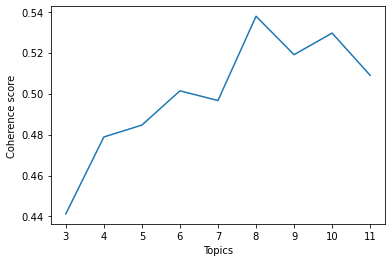

In [19]:
import matplotlib.pyplot as plt

start=3
end=12
x = range(start, end)
plt.plot(x, coherences)
plt.xlabel("Topics")
plt.ylabel("Coherence score")
plt.show()

In [20]:
# Метрика
for m, cv in zip(x, coherences):
    print("Topics =", m, "- Coherence score:", round(cv, 4))

Topics = 3 - Coherence score: 0.4413
Topics = 4 - Coherence score: 0.4788
Topics = 5 - Coherence score: 0.4846
Topics = 6 - Coherence score: 0.5014
Topics = 7 - Coherence score: 0.4966
Topics = 8 - Coherence score: 0.5378
Topics = 9 - Coherence score: 0.519
Topics = 10 - Coherence score: 0.5296
Topics = 11 - Coherence score: 0.5089


Таким образом, наибольшее значение согласованности достигается для 8 тем.

In [21]:
best_model = models[5]

In [22]:
# сохранение результатов
#
best_model.save("model_8topics.gensim")
#
with open("coherences.txt", "wb") as fp:
    pickle.dump(coherences, fp)

# import pickle
# with open("coherences.txt", "rb") as fp:
#     coherences = pickle.load(fp)

In [23]:
best_model = models.wrappers.LdaMallet.load('model_8topics.gensim')

In [24]:
model_topics = best_model.show_topics(formatted=False)
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.064*"mutant" + 0.060*"mutation" + 0.025*"result" + 0.023*"chromosome" + '
  '0.022*"phenotype" + 0.020*"animal" + 0.020*"function" + 0.020*"wild_type" + '
  '0.018*"defect" + 0.017*"male"'),
 (1,
  '0.030*"neuron" + 0.021*"receptor" + 0.019*"response" + 0.017*"animal" + '
  '0.011*"muscle" + 0.011*"body" + 0.011*"type" + 0.011*"behavior" + '
  '0.010*"dauer" + 0.010*"change"'),
 (2,
  '0.052*"sequence" + 0.027*"region" + 0.019*"site" + 0.016*"find" + '
  '0.016*"family" + 0.014*"amino_acid" + 0.014*"conserve" + 0.014*"encode" + '
  '0.013*"clone" + 0.012*"element"'),
 (3,
  '0.022*"nematode" + 0.019*"increase" + 0.016*"effect" + 0.015*"high" + '
  '0.013*"level" + 0.013*"worm" + 0.011*"growth" + 0.010*"strain" + '
  '0.010*"rate" + 0.010*"test"'),
 (4,
  '0.041*"study" + 0.025*"genetic" + 0.021*"organism" + 0.021*"model" + '
  '0.019*"molecular" + 0.018*"system" + 0.017*"analysis" + 0.012*"provide" + '
  '0.012*"describe" + 0.010*"datum"'),
 (5,
  '0.042*"expression" + 0.039*

Все документы связаны с круглыми червями (Nematoda). Каждая тема характеризует отдельный раздел, изучающий особенности нематод.

Характеристика тем:
* Topic 0 - **Генетика**
  - мутант, мутация, хромосома, фенотип
* Topic 1 - **Сенсорные системы, неврология**
  - нейрон, рецептор, отклик, поведение 
* Topic 2 - **Цитология (Cell biology)**
  - последовательность, область, аминокислота, сохранить, кодировать, клонировать 
* Topic 3 - **Жизненный цикл (размножение)**
  - нематода, червь, увеличение, рост, штамм
* Topic 4 - **Молекулярная биология**
  - исследование, генетический, организм, модель, молекулярный, система, анализ
* Topic 5 - **Взаимодействие**
  - выражение, функция, сигнал, путь, активность, регулировать, посредничать
* Topic 6 - **Биология развития**
  - развитие, эмбрион, ранний, шаблон, происхождение, эмбриональный
* Topic 7 - **Структура и функции белка**
  - белок, домен, связывание, структура, мышца

### 4. Визуализация

In [25]:
import pyLDAvis.gensim
import gensim 

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.025368  0.268057       1        1  12.822766
3      0.226860 -0.009622       2        1  12.742895
5     -0.220519  0.024342       3        1  12.730001
6     -0.095713 -0.253996       4        1  12.652087
7     -0.255896  0.154713       5        1  12.572010
4      0.261000  0.079810       6        1  12.495540
0      0.047347 -0.049107       7        1  12.412597
1      0.011554 -0.214199       8        1  11.572104, topic_info=           Term         Freq        Total Category  logprob  loglift
782     protein  6409.000000  6409.000000  Default  30.0000  30.0000
13       mutant  3410.000000  3410.000000  Default  29.0000  29.0000
14     mutation  3150.000000  3150.000000  Default  28.0000  28.0000
358    sequence  2820.000000  2820.000000  Default  27.0000  27.0000
420  expression  2296.000000  2296.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
88    formation   266.273804   765.103445   Topic8  -5.2218   1.1011
264        long   245.964785   554.050865   Topic8  -5.3011   1.3445
162        form   277.556592  1135.515865   Topic8  -5.1803   0.7478
71         show   323.816024  2914.724321   Topic8  -5.0261  -0.0408
132   mechanism   258.375852  1273.137937   Topic8  -5.2519   0.5617

[661 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
146       7  0.998074            abnormal
8775      3  0.960407            accepter
3077      5  1.009711              acidic
2097      5  0.998892               actin
631       2  0.083227              action
...     ...       ...                 ...
6472      8  0.886306             xenopus
628       6  0.997104                year
840       1  0.841384               yeast
840       3  0.160495               yeast
3965      1  1.009575  yeast_saccharomyce

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 7, 8, 5, 1, 2])

In [28]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [29]:
# Получение доминирующие темы и весов тем для каждого документа
def topics_per_document(model, corpus):
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus)    

In [30]:
# Отбор документов с более значимыми весами, для лучшей визуализации
weights = np.array([[x[1] for x in percentages] for percentages in topic_percentages])
weights = weights[np.amax(weights, axis=1) > 0.25]
# Список основных тем для отобранных документов
topic_num = np.argmax(weights, axis=1)

Визуализация кластеров.

In [31]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3852 samples in 0.002s...
[t-SNE] Computed neighbors for 3852 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3852
[t-SNE] Computed conditional probabilities for sample 2000 / 3852
[t-SNE] Computed conditional probabilities for sample 3000 / 3852
[t-SNE] Computed conditional probabilities for sample 3852 / 3852
[t-SNE] Mean sigma: 0.039056
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.190231
[t-SNE] KL divergence after 1000 iterations: 1.103716


In [32]:
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

In [33]:
# Общее количество документов, относящихся к каждой теме
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

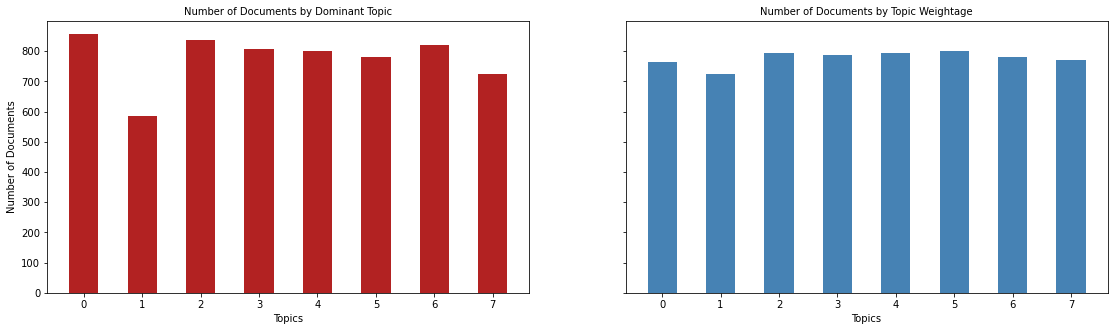

In [34]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5), sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Визуализация тем подтверждает качество разделения.